## Supervised learning and decoding with manifold GPLVMs
_Kristopher T. Jensen (February, 2022); ktj21@cam.ac.uk_

In this short example notebook, we fit mGPLVM as a _supervised_ learning model (based on Jensen, Kao, Tripodi & Hennequin, NeurIPS 2020).

The general specification of mGPLVM is a latent variable model where the objective is to maximize the marginal likelihood:
$$p(Y) = \int p_{\theta}(Y|Z) p(Z) dZ,$$
where $p(Y|Z)$ is a Gaussian processes, $Y \in \mathbb{R}^{N \times T}$ are neural recordings, and $Z \in T^1$ are some latent variables on a circle (note that everything readily generalizes to higher-dimensional Euclidean and non-Euclidean manifolds).

However, in the supervised setting, $p(Z)$ is a _delta function_ during training, and we can simply optimize the parameters $\theta$ of the generative model $p_{\theta}(Y_{train}|Z_{train})$ without worrying about inferring $Z$:\
$$\theta^* = \text{argmax}_\theta \left [ \log p_{\theta}(Y_{train}|Z_{train}) \right ].$$

After training, we need to perform inference on the _test data_ $Y^*$ to find the latent variables $Z^*$ given the training data $\{ Y_{train}, Z_{train} \}$.
This takes the form\
$$p(Z^*|Y^*, \{Y_{train}, Z_{train}\}) \propto p_{\theta}(Y^* | Z^*, \{Y_{train}, Z_{train}\}) p(Z^*),$$
where $p_{\theta}(Y^* | Z^*, \{Y_{train}, Z_{train}\})$ is given by the standard predictive GP equations.
This is of course difficult, and we resort to variational inference using the mGPLVM machinery, but now with frozen generative parameters $\theta^*$.

For the prior $p(Z^*)$ we have two main options:\
(i) we can assume a uniform, uninformative prior.\
(ii) we can fit the prior to the training data.
The simplest approach here is to define an autoregressive prior that matches the distribution over displacements in the training data. For continuous processes with high temporal resolution, this can be a very strong and useful prior!

See Jensen et al. (2020) for further details about the generative model and inference procedure. Further developments on auto-regressive priors and non-Gaussian noise models were presented at Cosyne 2021 but have not been published.

We start by installing the mGPLVM implementation used in Jensen et al. This is freely available, but the codebase is still under active development with ongoing work on various latent variable models (here we use the 'bGPFA' branch which is most up-to-date).

We proceed to load a few packages and set our random seed.

In [1]:
#@title Load packages
import time
tic = time.time()
import torch
import mgplvm as mgp
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binned_statistic, pearsonr, ttest_1samp
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
device = mgp.utils.get_device() # use GPU if available, otherwise CPU

loading


In [2]:
seed = 0 #set the seed
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
#@title Define plot functions

def plot_activity_heatmap(Y):
  ### plot the activity of our neurons ###
  plt.figure(figsize = (12, 6))
  plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
  plt.xlabel('time')
  plt.ylabel('neuron')
  plt.title('Raw activity', fontsize = 25)
  plt.xticks([])
  plt.yticks([])
  plt.show()

def plot_tuning_curves(fit_thetas, ys_noise, plot_thetas, ys, ys_lin, ys_bins, ys_gp, xs_bins):
  plt.figure(figsize = (5,3.0))
  plt.scatter(fit_thetas, ys_noise, color = "k", alpha = 0.2)
  plt.plot(plot_thetas, ys, 'k-')
  plt.plot(plot_thetas, ys_lin, 'b-')
  plt.plot(xs_bins, ys_bins, 'g-')
  plt.plot(plot_thetas, ys_gp, 'm-')
  plt.legend(['true', 'linear', 'binned', 'GP'], frameon = False, ncol = 2, loc = 'upper center', bbox_to_anchor = [0.5, 1.4])
  plt.xlim(-np.pi, np.pi)
  plt.xlabel('theta')
  plt.ylabel('activity')
  plt.yticks([])
  plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', r'$0$', r'$\pi$'])
  plt.show()

def cb(mod, i, loss):
  """here we construct an (optional) function that helps us keep track of the training"""
  if i in [0, 50, 100, 150, 300, 500, 1000, 1500, 1999]: #iterations to plot
    X = mod.lat_dist.prms[0].detach().cpu().numpy()[0, ...]
    X = X % (2*np.pi)
    plt.figure(figsize = (4,4))
    plt.xlim(0, 2*np.pi); plt.ylim(0, 2*np.pi)
    plt.xlabel("true latents"); plt.ylabel("model latents")
    plt.scatter(thetas_plot, X[:, 0], color = 'k')
    plt.title('iter = '+str(i))
    plt.show()
    print(mod.lat_dist.msg(Y, None, None) + mod.svgp.msg + mod.lprior.msg, loss/n_ts1)

def plot_final_thetas(thetas2, thetas2_lin, thetas2_mgplvm):
  plt.figure()
  plt.scatter(thetas2, thetas2_lin, color = "b")
  plt.scatter(thetas2, thetas2_mgplvm, color = "k")
  plt.legend(['linear', 'mgplvm'], frameon = False, ncol = 2, loc = 'upper center', bbox_to_anchor = (0.5, 1.25))
  plt.xlabel('true theta')
  plt.ylabel('predicted theta')
  plt.show()

def plot_final_errors(errs_lin, errs_mgplvm, bins):
  plt.figure()
  plt.hist(errs_lin, bins = bins, color = 'b', alpha = 0.2)
  plt.hist(errs_mgplvm, bins = bins, color = 'k', alpha = 0.2)
  plt.axvline(np.mean(errs_lin), color = 'b', lw = 3)
  plt.axvline(np.mean(errs_mgplvm), color = 'k', lw = 3)
  plt.xlabel('error')
  plt.ylabel('frequency')
  plt.legend(['linear', 'mgplvm'], frameon = False)
  plt.show()

def plot_uncertainty_estimates(xs, errs_by_uncertainty):
  #xs, errs_by_uncertainty = xs**2, errs_by_uncertainty**2 #variances instead of stds
  plt.figure(figsize = (5,5))
  plt.scatter(xs, errs_by_uncertainty, color = "k")
  plt.plot([xs[0], xs[-1]], [xs[0], xs[-1]], "k-")
  plt.xlabel("uncertainty")
  plt.ylabel("RMSE")
  plt.xticks([0.15, 0.20, 0.25])
  plt.yticks([0.15, 0.20, 0.25])
  plt.show()

In order to validate the method, we generate synthetic data from 40 neurons and 100 time points, assuming 'Gaussian bump'-like tuning curves and Gaussian noise.
We use this fairly sparse dataset to illustrate the data efficiency of this approach, but it would of course also work with more data.
We also note that the codebase readily allows for Poisson or negative binomial noise models.

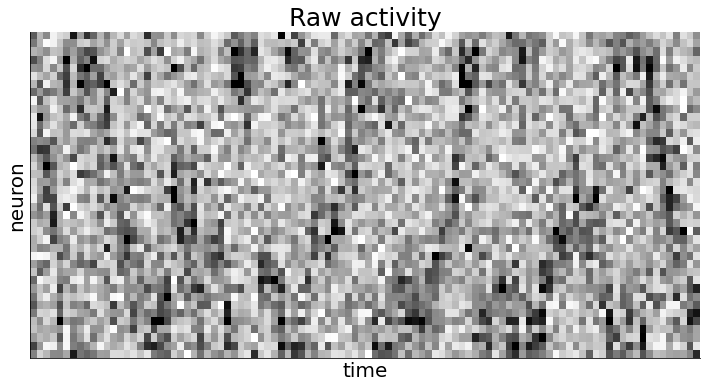

In [4]:
### generate some synthetic data ###

n_ts = 600 #total time points
n_ts1 = 100 #training time points
n_neurons = 40 #number of neurons

thetas = np.zeros(n_ts) #generate a sequence of angles as an autoregressive process
for i in range(1, n_ts):
  thetas[i] = (thetas[i-1] + np.random.normal()) % (2*np.pi)

prefs = np.sort(np.random.uniform(0, 2*np.pi, n_neurons)) #preferred orientations
deltas = prefs[:, None] - thetas[None, :] #difference from head direction
gs = np.random.uniform(0.5, 1.5, n_neurons) #scale variables
kappas = np.random.uniform(2, 4, n_neurons) #concentration parameters
#generate activity
Y = gs[:, None] * np.exp( kappas[:, None]*( np.cos(deltas) - 1 ) ) + np.random.normal(0, 0.5, (n_neurons, n_ts))
Y = Y[None, ...]

#split into train and test
Y1 = Y[:, :, :n_ts1] #train
thetas1 = thetas[:n_ts1]
Y2 = Y[:, :, n_ts1:] #test

### plot the training data we just generated ###
plot_activity_heatmap(Y1)

In this next code snippet, we consider why fitting this GPLVM-based model might be a good idea.
To do this, we consider an example neuron from above and try to approximate its tuning using three different approached.

The first is by assuming linearity in $[\cos\theta, \sin \theta]$ which is what many linear decoders of angles do.
However, this enforces a sinusoidal tuning curve which does not fit the data well.

The second is to bin the data and construct an empirical tuning curve as the average activity in each bin (note that this corresponds to a Gaussian noise model, and we could equally well use non-Gaussian noise models).
However, this requires us to specify _a priori_ what the resolution is, and it leads to non-intuitive discontinuities.
This is the approach taken by many standard Bayesian decoders.
In fact, this is equivalent to fitting a Gaussian Process with a kernel that is constant within each bin and discontinuous between bins.

Alternatively, we can posit that the expected similarity of neural activity is not discrete but rather a function of distance on the circle.
We do this by fitting a Gaussian process to the data with a kernel that ensures smoothness/continuity on the circle.
Importantly, the length scale can now be learned directly from the data and there are no discontinuities.
This is particularly important in the limited-data regime, and we see that this model fits the data better.

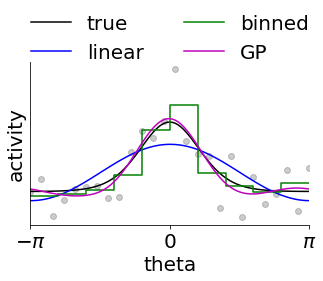

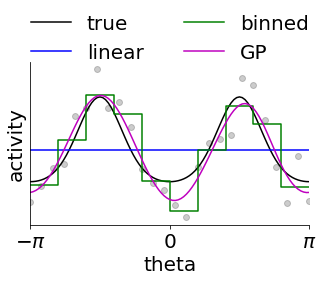

In [5]:
plot_thetas = np.linspace(-np.pi, np.pi, 101) #values to use for plotting
inds = np.arange(0, len(plot_thetas), 4) #only record a subset of angles

for example in range(2):
  if example == 0: #single neuron
    ys = 1.4 * np.exp( 2.3*( np.cos(plot_thetas) - 1 ) ) #tuning curve
    ell = 1/np.sqrt(2.3)
  else:
    ys1 = 1.4 * np.exp( 4*( np.cos(plot_thetas + 0.5*np.pi) - 1 ) ) #tuning curve
    ys2 = 1.4 * np.exp( 4*( np.cos(plot_thetas - 0.5*np.pi) - 1 ) ) #tuning curve
    ys = ys1+ys2
    ell = 1/np.sqrt(4)

  ys_noise = (ys + np.random.normal(0, 0.3, len(plot_thetas)))[inds] #noisy data
  fit_thetas = plot_thetas[inds] #supervised angles for our noisy data

  ### fit the linear model ###
  cs_plot = np.array([np.cos(plot_thetas), np.sin(plot_thetas)]).T #cos/sin
  cs_fit = cs_plot[inds, :] #for our noisy data data
  clf_single = RidgeCV(alphas=10**np.linspace(-5,5,51)).fit(cs_fit, ys_noise[:, None]) #crossvalidated ridge regression
  ys_lin = clf_single.predict(cs_plot) #fitted tuning curve

  ### binned decoder ###
  bins = np.linspace(-np.pi, np.pi, 11) #assume 11 bins for now
  ys_bins = binned_statistic(fit_thetas, ys_noise, bins = bins)[0] #activity in each bin
  ys_bins = np.repeat(ys_bins, 2) #expand for plotting
  xs_bins = np.repeat(bins, 2)[1:-1] #expand for plotting

  ### fit out GP-based model ###
  def K(x1, x2, ell = 0.75, sig = 0.3):
    '''for illustration purposes, we pick some reasonable parameters but these could be learned from data'''
    Kmat = np.exp( (np.cos(x1[:, None] - x2[None, :]) - 1) / (2*ell**2) )
    if (sig > 0) and (x1.shape == x2.shape): Kmat += sig*np.eye(len(fit_thetas))
    return Kmat
  #GP inference
  ys_gp = K(plot_thetas, fit_thetas, sig = 0, ell = ell) @ np.linalg.inv(K(fit_thetas, fit_thetas, ell = ell)) @ ys_noise
  ys_gp = ys_gp.flatten()

  ### plot result ###
  plot_tuning_curves(fit_thetas, ys_noise, plot_thetas, ys, ys_lin, ys_bins, ys_gp, xs_bins)


Having gained some intuition for the benefits of Gaussian process-based models, we are ready to construct our full mGPLVM for decoding. In the following code snippet, we set a couple of model parameters relating to the optimization process and initialization. Most of the initialization is done directly from the data, but it can be useful to include if we have prior knowledge about e.g. the timescale of the behavior we care about.

In [6]:
### set some parameters for fitting ###
max_steps = 1001 # number of training iterations
n_mc = 1 # number of monte carlo samples per iteration (since the latents are a delta function, we only need 1)
print_every = 100 # how often we print training progress
d_latent = 1 # specify the dimensionality of the space
n_z = 10 #number of inducing points; performance increases with more inducing points

Having specified our parameters, we can construct the mGPLVM model.
In this particular library, we need to separately specify (i) the noise model, (ii) the latent manifold (see Jensen et al. 2020 for various manifolds), (iii) the prior and variational distribution, and (iv) the GP kernel.

For this dataset we use a Gaussian noise model, but we can easily swap in a count-based model.
Note how we set the latent distribution to be centered at the ground truth thetas and have a very small standard deviation (1e-5; effectively a delta function).

In [7]:
### construct the actual model ###
n_trials, n_neurons, n_ts1 = Y1.shape
data1 = torch.Tensor(Y1).to(device)

manif = mgp.manifolds.Torus(n_ts1, d_latent) # our latent variables live on a ring (see Jensen et al. 2020 for alternatives)
likelihood = mgp.likelihoods.Gaussian(n_neurons, Y = Y1, d = d_latent) #Gaussian noise
mu = thetas1[None, :, None] #ground truth thetas for training
lat_dist = mgp.rdist.ReLie(manif, n_ts1, n_trials, sigma = 1e-5, diagonal = True, mu = mu) #latent distribution

lprior = mgp.lpriors.Uniform(manif) #note that we could also learn the generative parameters of a parametric prior
kernel = mgp.kernels.QuadExp(n_neurons, manif.distance, Y = Y1, ell = np.ones(n_neurons)*1, scale = 0.7*np.ones(n_neurons)) #squared exponential kernel
z = manif.inducing_points(n_neurons, n_z) #inducing points
mod = mgp.models.SvgpLvm(n_neurons, n_ts1, n_trials, z, kernel, likelihood, lat_dist, lprior).to(device) #construct model

We are now ready to actually learn the generative parameters!

fitting 40 neurons and 100 time bins for 1001 iterations
iter   0 | elbo -3.913 | kl  0.298 | loss  3.913 | |mu| 3.944 | sig 0.000 | scale 0.700 | ell 1.000 | lik_sig 0.836 |


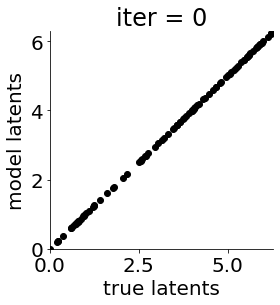

 |mu| 3.944 | sig 0.000 | scale 0.700 | ell 1.000 | lik_sig 0.836 | 156.5077596119108
iter  50 | elbo -1.056 | kl  0.297 | loss  1.244 | |mu| 3.944 | sig 0.000 | scale 0.664 | ell 1.160 | lik_sig 0.834 |


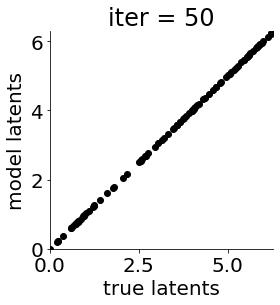

 |mu| 3.944 | sig 0.000 | scale 0.664 | ell 1.160 | lik_sig 0.834 | 49.74203195518805
iter 100 | elbo -0.843 | kl  0.300 | loss  1.103 | |mu| 3.944 | sig 0.000 | scale 0.630 | ell 1.303 | lik_sig 0.531 |


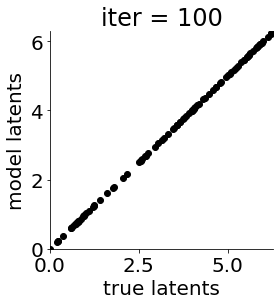

 |mu| 3.944 | sig 0.000 | scale 0.630 | ell 1.303 | lik_sig 0.531 | 44.10655420896538
iter 150 | elbo -0.804 | kl  0.298 | loss  1.087 | |mu| 3.944 | sig 0.000 | scale 0.596 | ell 1.366 | lik_sig 0.511 |


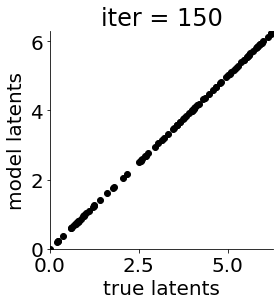

 |mu| 3.944 | sig 0.000 | scale 0.596 | ell 1.366 | lik_sig 0.511 | 43.48937458010431
iter 200 | elbo -0.794 | kl  0.296 | loss  1.085 | |mu| 3.944 | sig 0.000 | scale 0.575 | ell 1.368 | lik_sig 0.504 |
iter 250 | elbo -0.790 | kl  0.297 | loss  1.084 | |mu| 3.944 | sig 0.000 | scale 0.560 | ell 1.354 | lik_sig 0.501 |
iter 300 | elbo -0.787 | kl  0.301 | loss  1.087 | |mu| 3.944 | sig 0.000 | scale 0.548 | ell 1.339 | lik_sig 0.499 |


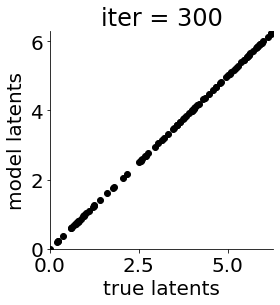

 |mu| 3.944 | sig 0.000 | scale 0.548 | ell 1.339 | lik_sig 0.499 | 43.49780433490198
iter 350 | elbo -0.786 | kl  0.300 | loss  1.086 | |mu| 3.944 | sig 0.000 | scale 0.539 | ell 1.324 | lik_sig 0.498 |
iter 400 | elbo -0.785 | kl  0.301 | loss  1.086 | |mu| 3.944 | sig 0.000 | scale 0.531 | ell 1.310 | lik_sig 0.497 |
iter 450 | elbo -0.785 | kl  0.300 | loss  1.084 | |mu| 3.944 | sig 0.000 | scale 0.524 | ell 1.298 | lik_sig 0.497 |
iter 500 | elbo -0.784 | kl  0.298 | loss  1.082 | |mu| 3.944 | sig 0.000 | scale 0.517 | ell 1.287 | lik_sig 0.496 |


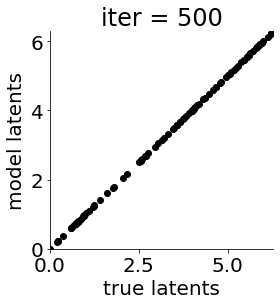

 |mu| 3.944 | sig 0.000 | scale 0.517 | ell 1.287 | lik_sig 0.496 | 43.275065719273954
iter 550 | elbo -0.784 | kl  0.295 | loss  1.079 | |mu| 3.944 | sig 0.000 | scale 0.511 | ell 1.277 | lik_sig 0.496 |
iter 600 | elbo -0.784 | kl  0.302 | loss  1.085 | |mu| 3.944 | sig 0.000 | scale 0.506 | ell 1.267 | lik_sig 0.496 |
iter 650 | elbo -0.783 | kl  0.300 | loss  1.083 | |mu| 3.944 | sig 0.000 | scale 0.501 | ell 1.258 | lik_sig 0.496 |
iter 700 | elbo -0.783 | kl  0.296 | loss  1.079 | |mu| 3.944 | sig 0.000 | scale 0.496 | ell 1.248 | lik_sig 0.495 |
iter 750 | elbo -0.783 | kl  0.297 | loss  1.080 | |mu| 3.944 | sig 0.000 | scale 0.492 | ell 1.237 | lik_sig 0.495 |
iter 800 | elbo -0.783 | kl  0.300 | loss  1.083 | |mu| 3.944 | sig 0.000 | scale 0.488 | ell 1.225 | lik_sig 0.495 |
iter 850 | elbo -0.783 | kl  0.297 | loss  1.080 | |mu| 3.944 | sig 0.000 | scale 0.484 | ell 1.212 | lik_sig 0.495 |
iter 900 | elbo -0.783 | kl  0.298 | loss  1.081 | |mu| 3.944 | sig 0.000 | scale 0.480

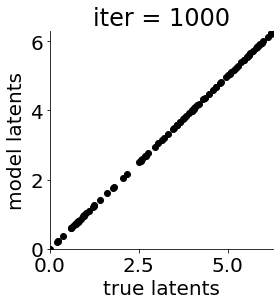

 |mu| 3.944 | sig 0.000 | scale 0.473 | ell 1.178 | lik_sig 0.495 | 43.314183433002384


In [8]:
t0 = time.time()
thetas_plot = thetas1

#note that the 'mask_Ts' function is a mask applied to the gradients for the variational distribution
#by setting these gradients to zero, we are imposing the ground truth latents and doing supervised training
train_params = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 5e-2, callback = cb, burnin = 50, mask_Ts = (lambda x: x*0))
print('fitting', n_neurons, 'neurons and', n_ts1, 'time bins for', max_steps, 'iterations')
mod_train = mgp.crossval.train_model(mod, data1, train_params)

We proceed to train a simple linear model which we will use as a baseline.
We also use the predictions of the linear model for initialization.

In [9]:
## first fit a linear model (we will use this for initialization and comparison) ##
Y2 = Y[..., n_ts1:] #test data
thetas2 = thetas[n_ts1:] #true test angles
Z1 = np.array([np.cos(thetas1), np.sin(thetas1)]).T #true training cos/sin
Z2 = np.array([np.cos(thetas2), np.sin(thetas2)]).T #true test cos/sin
print(Y1.shape, Z1.shape)

alphas = 10**(np.linspace(-4, 4, 51)) #possible regularization strengths
clf = RidgeCV(alphas=alphas).fit(Y1[0, ...].T, Z1) #crossvalidated ridge regression
Z2_pred = clf.predict(Y2[0, ...].T) #predict test data
Z2_pred = Z2_pred / np.sqrt(np.sum(Z2_pred**2, axis = 1, keepdims = True)) #normalize
thetas2_lin = (np.sign(Z2_pred[:, 1]) * np.arccos(Z2_pred[:, 0])) % (2*np.pi) #predicted angles

(1, 40, 100) (100, 2)


We're now ready for the prediction step.
Here we copy over all parameters from our previous model apart from the variational distribution which we define anew.

In [10]:
### now we want to do decoding ###
_, _, n_ts2 = Y2.shape
manif2 = mgp.manifolds.Torus(n_ts2, d_latent) # latent manifold is still a circle

#compute displacements to use a better prior
displacements = thetas1[1:] - thetas1[:-1]
displacements[displacements < -np.pi] += 2*np.pi
displacements[displacements > np.pi] -= 2*np.pi
print(np.std(displacements)) #matches generative process

mu2 = thetas2_lin[None, :, None] #initialize from linear prediction

#lprior2 = mgp.lpriors.Uniform(manif2) #uniform prior
#let's assume some degree of continuity in the data
lprior2 = mgp.lpriors.Brownian(manif2, fixed_brownian_c = True, fixed_brownian_eta = True,
                              brownian_eta = torch.ones(d_latent) * np.var(displacements))

lat_dist2 = mgp.rdist.ReLie(manif2, n_ts2, n_trials, sigma = 0.5, diagonal = True, mu = mu2) #variational distribution


1.0123699125250345


In [11]:
#@title Construct inference model
data2 = torch.Tensor(Y2).to(device) #put data on device
mod2 = mgp.models.SvgpLvm(n_neurons, n_ts2, n_trials, z.cpu(), kernel.cpu(), likelihood.cpu(), lat_dist2, lprior2).to(device) #use old generative model and new variational distribution
for p in mod2.parameters():  #no gradients for generative parameters
  p.requires_grad = False
for p in mod2.lat_dist.parameters(): #only inference
  p.requires_grad = True
#copy over tuning curves (this summarizes p(Y*|Z*, {Y, Z}) from the training data in the SVGP framework)
mod2.svgp.q_mu[...] = mod.svgp.q_mu[...].detach()
mod2.svgp.q_sqrt[...] = mod.svgp.q_sqrt[...].detach()

Finally we infer our new latents using the mGPLVM machinery!

fitting 40 neurons and 500 time bins for 1001 iterations
iter   0 | elbo -0.896 | kl  0.024 | loss  0.896 | |mu| 3.670 | sig 0.500 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |


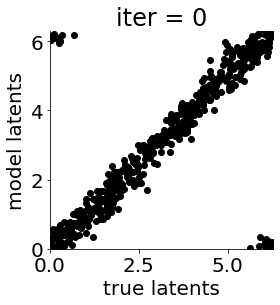

 |mu| 3.670 | sig 0.500 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 179.19064879098534
iter  10 | elbo -0.871 | kl  0.025 | loss  0.896 | |mu| 3.669 | sig 0.445 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  20 | elbo -0.851 | kl  0.026 | loss  0.877 | |mu| 3.673 | sig 0.384 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  30 | elbo -0.839 | kl  0.028 | loss  0.867 | |mu| 3.679 | sig 0.335 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  40 | elbo -0.828 | kl  0.031 | loss  0.859 | |mu| 3.683 | sig 0.295 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  50 | elbo -0.820 | kl  0.034 | loss  0.854 | |mu| 3.686 | sig 0.265 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |


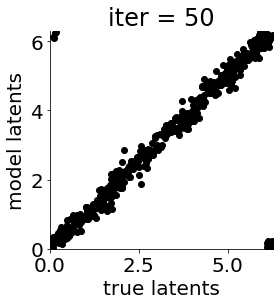

 |mu| 3.686 | sig 0.265 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 170.80025111998782
iter  60 | elbo -0.816 | kl  0.035 | loss  0.851 | |mu| 3.685 | sig 0.242 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  70 | elbo -0.812 | kl  0.037 | loss  0.849 | |mu| 3.684 | sig 0.225 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  80 | elbo -0.810 | kl  0.039 | loss  0.848 | |mu| 3.684 | sig 0.212 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter  90 | elbo -0.807 | kl  0.040 | loss  0.847 | |mu| 3.687 | sig 0.202 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 100 | elbo -0.806 | kl  0.041 | loss  0.847 | |mu| 3.686 | sig 0.193 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |


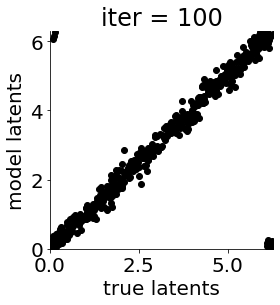

 |mu| 3.686 | sig 0.193 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 169.3359999584735
iter 110 | elbo -0.804 | kl  0.042 | loss  0.846 | |mu| 3.687 | sig 0.186 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 120 | elbo -0.804 | kl  0.042 | loss  0.846 | |mu| 3.685 | sig 0.181 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 130 | elbo -0.803 | kl  0.043 | loss  0.846 | |mu| 3.685 | sig 0.177 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 140 | elbo -0.803 | kl  0.043 | loss  0.846 | |mu| 3.686 | sig 0.174 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 150 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.171 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |


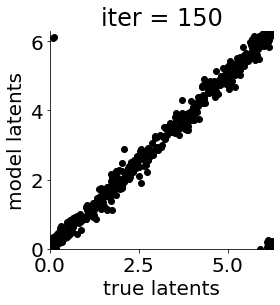

 |mu| 3.686 | sig 0.171 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 169.16463894396955
iter 160 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.170 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 170 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.168 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 180 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.167 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 190 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.166 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 200 | elbo -0.802 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.164 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 210 | elbo -0.801 | kl  0.044 | loss  0.846 | |mu| 3.685 | sig 0.164 | scale 0

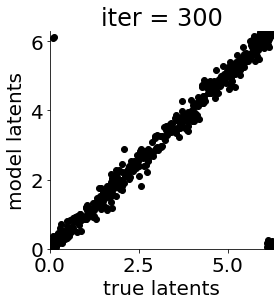

 |mu| 3.684 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 169.1358956642593
iter 310 | elbo -0.801 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 320 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.685 | sig 0.163 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 330 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.687 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 340 | elbo -0.801 | kl  0.044 | loss  0.846 | |mu| 3.685 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 350 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.686 | sig 0.164 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 360 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.687 | sig 0.163 | scale 0.

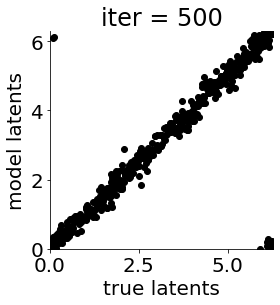

 |mu| 3.685 | sig 0.163 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 169.16159645689314
iter 510 | elbo -0.801 | kl  0.044 | loss  0.846 | |mu| 3.686 | sig 0.163 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 520 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.687 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 530 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.685 | sig 0.163 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 540 | elbo -0.801 | kl  0.044 | loss  0.846 | |mu| 3.685 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 550 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.686 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 |
iter 560 | elbo -0.801 | kl  0.045 | loss  0.846 | |mu| 3.686 | sig 0.162 | scale 0

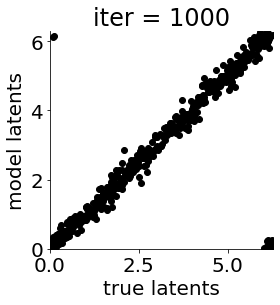

 |mu| 3.688 | sig 0.162 | scale 0.473 | ell 1.178 | lik_sig 0.495 | brownian_c 0.000 | brownian_eta 1.025 | 169.15263993430926


In [12]:
t0 = time.time()
thetas_plot = thetas2

# helper function to specify training parameters. We now do not mask the gradients.
train_params2 = mgp.crossval.training_params(max_steps = max_steps, n_mc = 20, lrate = 2e-2, print_every = 10, callback = cb, burnin = 1, mask_Ts = (lambda x: x*1))
print('fitting', n_neurons, 'neurons and', n_ts2, 'time bins for', max_steps, 'iterations')
mod_train2 = mgp.crossval.train_model(mod2, data2, train_params2) #inference!

We can then compare the performance of the simple linear decoder and our non-linear non-Euclidean mGPLVM-based decoder.

(500,) (500,) (500,)


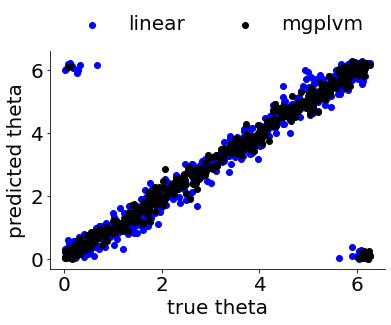

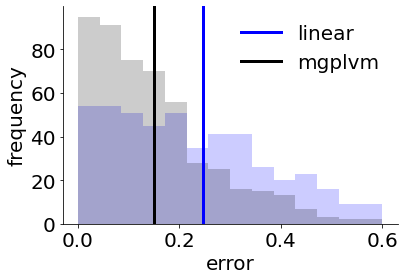

average errors: 0.24719006903707 (linear), 0.1495513829871003 (mgplvm)

Ttest_1sampResult(statistic=11.06075729330881, pvalue=1.3881822209953397e-25)


In [13]:
#let's do some simple evaluation

#plot inferred vs true angles
thetas2_mgplvm = mod2.lat_dist.prms[0].detach().cpu().numpy()[0, :, 0] % (2*np.pi) #mgplvm prediction
print(thetas2.shape, thetas2_lin.shape, thetas2_mgplvm.shape)
plot_final_thetas(thetas2, thetas2_lin, thetas2_mgplvm)

#compute errors in absolute distance
errs_lin, errs_mgplvm = [np.arccos(np.cos(thetas2 - arr)) for arr in [thetas2_lin, thetas2_mgplvm]]
bins = np.linspace(0, 0.6, 15)
plot_final_errors(errs_lin, errs_mgplvm, bins)

#print some summary statistics
print('average errors:', np.mean(errs_lin), '(linear),', np.mean(errs_mgplvm), '(mgplvm)\n') #print errors
print(ttest_1samp(errs_lin-errs_mgplvm, 0)) #statistical test

Finally, we note that the mGPLVM decoder also provides uncertainty estimates in the form of a full distribution over $p(Z^* | Y^*)$.
Here, we shower that these uncertainty estimates are in fact well-calibrated, suggesting that they can be useful for uncertainty-sensitive downstream applications and analyses.

68.3% ci: 63.800000000000004
95.4% ci: 91.8
[75 75 75 75 75 75 50]


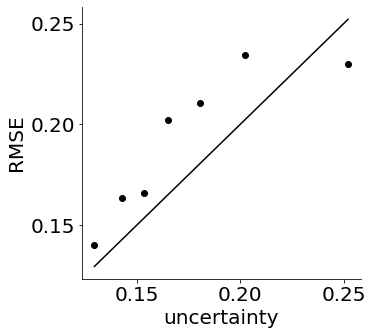

correlation: (0.8755737655495163, 0.009798358756537113)
total duration: 100.79450035095215


In [14]:
## check whether our uncertainty estimates are well-calibrated##
sigmas = mod2.lat_dist.prms[1].detach().cpu().numpy()[0, :, 0, 0] #model uncertainty
print('68.3% ci:', 100*np.mean(errs_mgplvm < sigmas))
print('95.4% ci:', 100*np.mean(errs_mgplvm < 2*sigmas))

### now check whether the empirical std of of the residuals matches the model uncertainty###
bins = np.concatenate([np.sort(sigmas)[::75], [np.inf]]) #construct some bins in which to compute errors
print(np.histogram(sigmas, bins = bins)[0]) #how many observations in each bin

def RMSE(residuals):
  '''compute RMSE for a set of residuals'''
  return np.sqrt(np.mean(residuals**2))

#compute std of the residuals for each uncertainty bin
errs_by_uncertainty = binned_statistic(sigmas, errs_mgplvm, statistic = RMSE, bins = bins)[0]
#binned x-values taking the average within each bin
xs = binned_statistic(sigmas, sigmas, statistic = RMSE, bins = bins)[0]

### plot RMSE vs uncertainty ###
plot_uncertainty_estimates(xs, errs_by_uncertainty)

print('correlation:', pearsonr(xs, errs_by_uncertainty))
print('total duration:', time.time() - tic)

##SO(3)
For those who have the courage, we now validate this approach on the group of 3D rotations (SO(3)).

In [15]:
#@title SO(3) helper functions

def quaternion_multiply(quaternion1, quaternion2):
  #this is q1 \times q2
  w1, x1, y1, z1 = quaternion1
  w2, x2, y2, z2 = quaternion2
  return np.array([-x1 * x2 - y1 * y2 - z1 * z2 + w1 * w2,
                    x1 * w2 + y1 * z2 - z1 * y2 + w1 * x2,
                    -x1 * z2 + y1 * w2 + z1 * x2 + w1 * y2,
                    x1 * y2 - y1 * x2 + z1 * w2 + w1 * z2])

def cb_so3(mod, i, loss):
  """here we construct an (optional) function that helps us keep track of the training"""
  if i in [0, 50, 100, 150, 250, 350, 500, 750, 1000, 1250, 1500, 1999]: #iterations to plot
    print(i, mod.lat_dist.msg(Y, None, None) + mod.svgp.msg + mod.lprior.msg, loss/n_ts1)



We start by generating some data on SO(3) using an autoregressive process.
We also construct a set of neurons with preferred firing fields on SO(3).

In [16]:
### Try SO(3) ###

### generate some synthetic data ###

tic = time.time()
n_ts = 800 #total time points
n_ts1 = 400 #training time points
n_neurons = 100 #number of neurons

#generate quaternions over time using an autoregressive process
qs_t = np.random.normal(0, 1, (n_ts, 4)) #random points on sphere
qs_t = qs_t / np.sqrt(np.sum(qs_t**2, axis = 1, keepdims = True)) #normalize
for t in range(1, n_ts): #autoregressive process
  step = np.random.normal(0, 0.4, 3) #displacement in tangent space
  theta = np.sqrt(np.sum(step**2))
  v = step / theta
  qt = np.concatenate([np.ones(1)*np.cos(theta), np.sin(theta)*v]) #displacement in quaternion space
  qs_t[t, :] = quaternion_multiply(qt, qs_t[t-1, :])
  #print(qs_t[t, :], np.sum(qs_t[t, :]**2), theta)
qs_t = np.sign(qs_t[:, :1]) * qs_t #consistent sign

#generate preferred orientation for each neuron
qs_n = np.random.normal(0, 1, (n_neurons, 4))
qs_n = qs_n / np.sqrt(np.sum(qs_n**2, axis = 1, keepdims = True))
qs_n = np.sign(qs_n[:, :1]) * qs_n #random quaternions
qs_n = qs_n[np.argsort(qs_n[:, 0]), :] #sort by first element for visualization

deltas = 4*( 1 - (qs_n @ qs_t.T)**2 ) #difference for each neuron/time (x^2 in small angle limit)

dt_dists = 4*( 1 - np.sum(qs_t[:-1, :] * qs_t[1:, :], axis = 1)**2 )
print('consecutive displacements:', np.quantile(dt_dists, [0.1, 0.25, 0.5, 0.75, 0.9]))
print('baseline/random:', np.quantile(deltas.flatten(), [0.1, 0.25, 0.5, 0.75, 0.9]))

consecutive displacements: [0.35885536 0.76547395 1.34929525 2.14503775 2.91410946]
baseline/random: [1.40482737 2.39040575 3.34394689 3.84129081 3.97570362]


We proceed to generate some synthetic neural activity and visualize it together with a couple of example tuning curves.

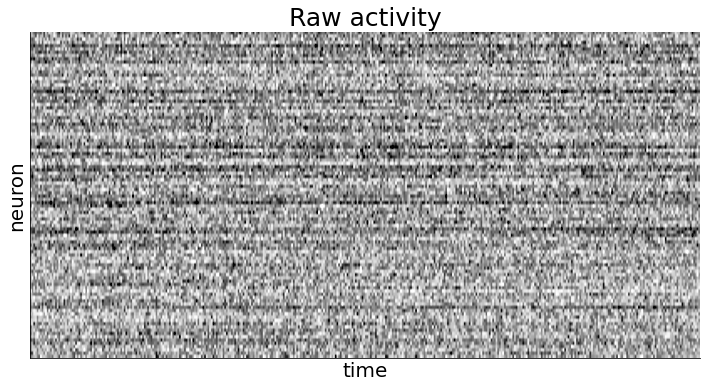



tuning curves:


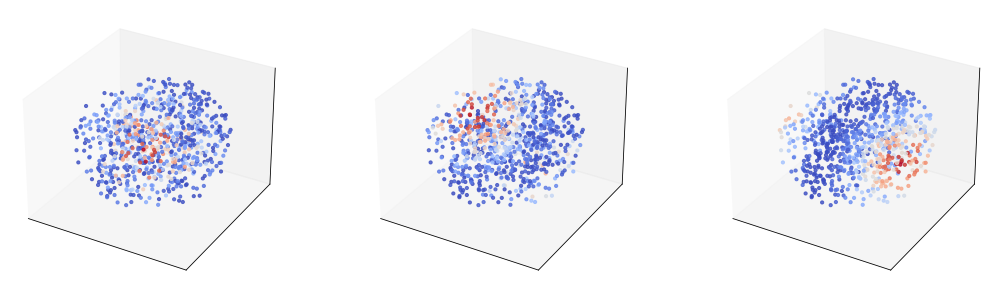

In [17]:
#generate activity
gs = np.random.uniform(0.5, 1.5, n_neurons) #scale variables
ells = np.random.uniform(1.0, 2, n_neurons) #concentration parameters
F = gs[:, None] * np.exp( - deltas / (2*ells[:, None]**2) )
Y = F + np.random.normal(0, 0.4, (n_neurons, n_ts))
Y = Y[None, ...]

#split into train and test
Y1 = Y[:, :, :n_ts1] #train
thetas1 = qs_t[:n_ts1, :]
Y2 = Y[:, :, n_ts1:] #test

### plot the training data we just generated ###
plot_activity_heatmap(Y1[:, :, np.argsort(qs_t[:n_ts1, 1])])

### also plot some example tuning curves ###
a = qs_t[..., :1]
theta = 2 * np.arccos(a)  #magnitude of rotation; ||x|| = theta/2
u = qs_t[..., 1:] / np.sqrt(np.sum(qs_t[..., 1:]**2, axis = -1, keepdims=True))
xs = 0.5 * theta * u

print('\n\ntuning curves:')
from mpl_toolkits import mplot3d
plt.figure(figsize = (15,4.5))
for i in range(3):
  ax = plt.subplot(1,3,i+1, projection='3d')
  n = np.random.choice(n_neurons)
  ax.scatter3D(xs[:, 0], xs[:, 1], xs[:,2], c = F[n, :], cmap = 'coolwarm', alpha = 0.8, s = 10)
  ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout()
plt.show()

We not construct our model.
In this case, we learn the parameters of the prior directly during model training (note that we could also have done this for the circle; we just defined the prior separately for clarity of exposition).

In [18]:
### set some parameters for fitting ###
max_steps = 1501 # number of training iterations
n_mc = 1 # number of monte carlo samples per iteration (since the latents are a delta function, we only need 1)
print_every = 100 # how often we print training progress
d_latent = 3 # specify the dimensionality of the space
n_z = 15 #number of inducing points; performance increases with more inducing points

### construct the actual model ###
n_trials, n_neurons, n_ts1 = Y1.shape
data1 = torch.Tensor(Y1).to(device)

manif = mgp.manifolds.So3(n_ts1, d_latent) # our latent variables live on SO(3) (see Jensen et al. 2020 for alternatives)
likelihood = mgp.likelihoods.Gaussian(n_neurons, Y = Y1, d = d_latent) #Gaussian noise
mu = qs_t[None, :n_ts1, :] #ground truth thetas for training
lat_dist = mgp.rdist.ReLie(manif, n_ts1, n_trials, sigma = 1e-5, diagonal = True, mu = mu) #latent distribution

#learn the prior!
lprior = mgp.lpriors.Brownian(manif, fixed_brownian_c = True, fixed_brownian_eta = False, brownian_eta = torch.ones(d_latent)*0.5**2)

kernel = mgp.kernels.QuadExp(n_neurons, manif.distance, Y = Y1, ell = np.ones(n_neurons)*1.0, scale = 0.7*np.ones(n_neurons)) #squared exponential kernel
z = manif.inducing_points(n_neurons, n_z) #inducing points
mod = mgp.models.SvgpLvm(n_neurons, n_ts1, n_trials, z, kernel, likelihood, lat_dist, lprior).to(device) #construct model

No we're ready to train the model!
This will take a bit longer since we're using more neurons and time points.

In [19]:
t0 = time.time()

train_params = mgp.crossval.training_params(max_steps = max_steps, n_mc = n_mc, lrate = 5e-2, callback = cb_so3, print_every = 27, burnin = 50, mask_Ts = (lambda x: x*0))
print('fitting', n_neurons, 'neurons and', n_ts1, 'time bins for', max_steps, 'iterations')
mod_train = mgp.crossval.train_model(mod, data1, train_params)

fitting 100 neurons and 400 time bins for 1501 iterations
iter   0 | elbo -4.234 | kl  414.281 | loss  4.234 | |mu| 0.500 | sig 0.000 | scale 0.700 | ell 1.000 | lik_sig 0.615 | brownian_c 0.000 | brownian_eta 0.250 |
0  |mu| 0.500 | sig 0.000 | scale 0.700 | ell 1.000 | lik_sig 0.615 | brownian_c 0.000 | brownian_eta 0.250 | 423.4367969499163
iter  27 | elbo -1.188 | kl  414.324 | loss  174.066 | |mu| 0.500 | sig 0.000 | scale 0.678 | ell 0.996 | lik_sig 0.678 | brownian_c 0.000 | brownian_eta 0.147 |
50  |mu| 0.500 | sig 0.000 | scale 0.645 | ell 1.048 | lik_sig 0.713 | brownian_c 0.000 | brownian_eta 0.156 | 26297.472139204503
iter  54 | elbo -1.030 | kl  415.259 | loss  275.269 | |mu| 0.500 | sig 0.000 | scale 0.639 | ell 1.063 | lik_sig 0.713 | brownian_c 0.000 | brownian_eta 0.158 |
iter  81 | elbo -0.915 | kl  414.933 | loss  333.734 | |mu| 0.500 | sig 0.000 | scale 0.594 | ell 1.196 | lik_sig 0.665 | brownian_c 0.000 | brownian_eta 0.161 |
100  |mu| 0.500 | sig 0.000 | scale 0.

For inference, we again initialize from a linear model - this time a linear model prediction orientations in quaternion space.

In [20]:
## first fit a linear model (we will use this for initialization and comparison) ##
Y2 = Y[..., n_ts1:] #test data
Z1, Z2 = qs_t[:n_ts1, :], qs_t[n_ts1:, :] #train/test quaternions
print(Y1.shape, Z1.shape)

alphas = 10**(np.linspace(-4, 4, 51)) #possible regularization strengths
clf = RidgeCV(alphas=alphas).fit(Y1[0, ...].T, Z1) #crossvalidated ridge regression
Z2_pred = clf.predict(Y2[0, ...].T) #predict test data
Z2_pred = Z2_pred / np.sqrt(np.sum(Z2_pred**2, axis = 1, keepdims = True)) #normalize
Z2_pred = np.sign(Z2_pred[:, :1]) * Z2_pred

errs_lin = 4*( 1 - np.sum(Z2 * Z2_pred, axis = 1)**2 )
errs_baseline = 4*( 1 - np.sum(np.array([1,0,0,0])[None, :] * Z2, axis = 1)**2 )
errs_baseline = deltas.flatten()

print('linear error:', np.quantile(errs_lin, [0.1, 0.25, 0.5, 0.75, 0.9]))
print('baseline/constant:', np.quantile(errs_baseline, [0.1, 0.25, 0.5, 0.75, 0.9]))

(1, 100, 400) (400, 4)
linear error: [0.2881247  0.66655339 1.59165241 3.06419977 3.79916018]
baseline/constant: [1.40482737 2.39040575 3.34394689 3.84129081 3.97570362]


This sets us up to construct our inference model.

In [21]:
### now we want to do decoding ###
_, _, n_ts2 = Y2.shape
manif2 = mgp.manifolds.So3(n_ts2, d_latent) # latent manifold is still So(3)
mu2 = Z2_pred[None, ...] #initialize from linear prediction
lat_dist2 = mgp.rdist.ReLie(manif2, n_ts2, n_trials, sigma = 0.4, diagonal = False, mu = mu2) #variational distribution
#in this case we do not define a new prior

In [22]:
#@title Construct SO(3) model

data2 = torch.Tensor(Y2).to(device) #put data on device
mod2 = mgp.models.SvgpLvm(n_neurons, n_ts2, n_trials, z.cpu(), kernel.cpu(), likelihood.cpu(), lat_dist2, lprior.cpu()).to(device) #use old generative model and new variational distribution
for p in mod2.parameters():  #no gradients for generative parameters
  p.requires_grad = False
for p in mod2.lat_dist.parameters(): #only inference
  p.requires_grad = True
#copy over tuning curves (this summarizes p(Y*|Z*, {Y, Z}) from the training data in the SVGP framework)
mod2.svgp.q_mu[...] = mod.svgp.q_mu[...].detach()
mod2.svgp.q_sqrt[...] = mod.svgp.q_sqrt[...].detach()

Finally we are ready to do inference!

In [23]:
t0 = time.time()

# helper function to specify training parameters. We now do not mask the gradients.
train_params2 = mgp.crossval.training_params(max_steps = max_steps, n_mc = 30, lrate = 2.5e-2, print_every = 10, callback = cb_so3, burnin = 1, mask_Ts = (lambda x: x*1))
print('fitting', n_neurons, 'neurons and', n_ts2, 'time bins for', max_steps, 'iterations')
mod_train2 = mgp.crossval.train_model(mod2, data2, train_params2) #inference!

fitting 100 neurons and 400 time bins for 1501 iterations
iter   0 | elbo -0.623 | kl  0.018 | loss  0.623 | |mu| 0.500 | sig 0.400 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 |
0  |mu| 0.500 | sig 0.400 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 | 62.2546900889882
iter  10 | elbo -0.599 | kl  0.018 | loss  0.617 | |mu| 0.500 | sig 0.336 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 |
iter  20 | elbo -0.584 | kl  0.020 | loss  0.603 | |mu| 0.500 | sig 0.273 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 |
iter  30 | elbo -0.574 | kl  0.021 | loss  0.595 | |mu| 0.500 | sig 0.230 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 |
iter  40 | elbo -0.568 | kl  0.023 | loss  0.591 | |mu| 0.500 | sig 0.202 | scale 0.384 | ell 3.552 | lik_sig 0.399 | brownian_c 0.000 | brownian_eta 0.161 |
iter  50 | elbo -0.564 | 

After performing inference, we compare our model to the linear and constant baselines and see that it vastly outperforms them.

(400, 4)
constant mean error: 2.206467350300819
linear mean error: 1.4969529603467293
mgplvm mean error: 0.6597242035160659


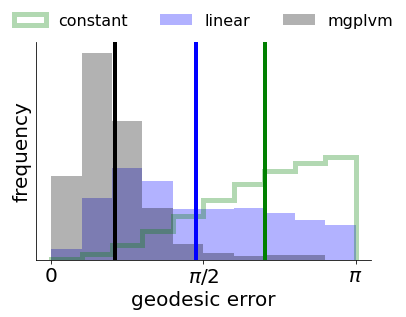

total time for SO(3): 180.98119020462036


In [24]:
Z2_mgplvm = mod2.lat_dist.prms[0].detach().cpu().numpy()[0, ...] #mgplvm prediction
print(Z2_mgplvm.shape)

errs_mgplvm = 4*( 1 - np.sum(Z2 * Z2_mgplvm, axis = 1)**2 )

cols = ['g', 'b', 'k']
bins = np.linspace(0, np.pi, 11)
#bins = np.linspace(0, np.pi**2, 11)
plt.figure()
labels = ['constant', 'linear', 'mgplvm']
for idat, dat in enumerate([errs_baseline, errs_lin, errs_mgplvm]):
  dat = np.arccos( 1 - 0.5*dat)
  #dat = dat**2
  plt.hist(dat, bins = bins, alpha = 0.3, color = cols[idat], density = True,
           histtype = ('step' if idat == 0 else 'bar'), lw = 5, label = labels[idat])
  plt.axvline(np.mean(dat), color = cols[idat], lw = 4)
  print(labels[idat]+' mean error:', np.mean(dat))
plt.xlabel('geodesic error')
plt.ylabel('frequency')
plt.yticks([])
plt.xticks([0, np.pi/2, np.pi], [r'$0$', r'$\pi / 2$', r'$\pi$'])
plt.legend(frameon = False, loc = 'upper center', bbox_to_anchor = (0.5, 1.2), ncol = 3, fontsize = 16)
plt.show()

print('total time for SO(3):', time.time() - tic)

-------------------------------------------------

The rest is legacy code that I used for debugging

In [25]:
# print(Y1 == Y2)
# print(thetas[:n_ts1] == thetas2)
# print(mod2, mod)

# print('\nkernel ell')
# print(mod.svgp.kernel.ell)
# print(mod2.svgp.kernel.ell)

# print('\nkernel scale')
# print(mod.svgp.kernel.scale_sqr)
# print(mod2.svgp.kernel.scale_sqr)

# print('\nlikelihood prms')
# print(mod.svgp.likelihood.prms)
# print(mod2.svgp.likelihood.prms)

# print('\ninducing points')
# print(mod.svgp.z.z[:3, 0, 0])
# print(mod2.svgp.z.z[:3, 0, 0])

# print('\nlat mu')
# print(mod.lat_dist.lat_prms()[0][0, :10, 0])
# print(mod2.lat_dist.lat_prms()[0][0, :10, 0])

# print('\nlat std')
# print(mod.lat_dist.lat_prms()[1][0, :10, 0])
# print(mod2.lat_dist.lat_prms()[1][0, :10, 0])

# print('\nqmu')
# print(mod.svgp.q_mu.requires_grad)
# print(mod2.svgp.q_mu.requires_grad)


# print(mod(data1, 10))
# print(mod2(data2, 10))

# print(len([p for p in mod.parameters()]))

# for p in mod2.parameters():
#   print(p.requires_grad)